In [1]:
# load packages and functions
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(magrittr))
suppressMessages(library(patchwork))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(tidyverse))
suppressMessages(library(viridis))
suppressMessages(library(ComplexHeatmap))

selected_markers<- c("CD45",
                     "CD172ab",
                     "CD8a",
                     "CD20",
                     "CD4",
                     "CD3",
                     "CD56",
                     "CCR6",
                     "CD45RA",
                     "MX1",
                     "CCR4",
                     "PU.1",
                     "SH2D1A",
                     "CD45RO",
                     "CXCR3",
                     "GZMK",
                     "TACTILE",
                     "PD-1",
                     "CTLA-4",
                     "CD69",
                     "CXCR5",
                     "CD15s",
                     "CD8b",
                     "CD25",
                     "CD39",
                     "TCF1",
                     "ICOS",
                     "AHR",
                     "Nur77",
                     "CCR2",
                     "CD161",
                     "FoxP3",
                     "CD40L",
                     "GZMB",
                     "Helios",
                     "CX3CR1",
                     "RORgt",
                     "CD127",
                     "GATA3",
                     "TIGIT",
                     "Ki67",
                     "T-bet",
                     "CCR7",
                     "CD57",
                     "HLA-DR",
                     "CD103",
                     "CD38",
                     "CD11b")

# set parameters
prop = 0.1
n_min = 10000
frac = 0.90
n_neighbors=30
min_dist=0.01
resolution_list=0.7

# cluster annotation
cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::filter(cell=="T") %>%
    dplyr::select(-cell) %>%
    dplyr::mutate(cluster = as.character(cluster))


In [2]:
exp_ds <- readRDS(file = "/projects/jinamo@xsede.org/cytof/data/T_cells/T_downsampled_Cells.rds")

`summarise()` has grouped output by 'subject_id__time'. You can override using
the `.groups` argument.


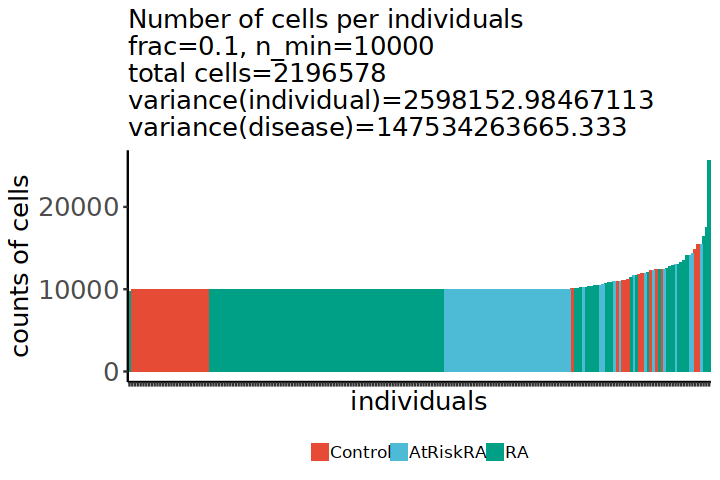

In [3]:
tmp = cbind(
  exp_ds %>%
    dplyr::group_by(subject_id__time) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::summarise(Total_cell_count=sum(cell_counts), ind_variance=var(cell_counts)),
  exp_ds %>%
    dplyr::group_by(disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::summarise(disease_variance=var(cell_counts))
)
options(repr.plot.height = 4, repr.plot.width = 6)
exp_ds %>%
       dplyr::group_by(subject_id__time, disease) %>%
       dplyr::summarise(cell_counts = n()) %>%
       dplyr::ungroup() %>%
       dplyr::arrange(desc(cell_counts)) %>%
       ggplot() + 
       geom_bar(aes(reorder(subject_id__time,cell_counts),cell_counts, fill = disease), stat = 'identity') + 
       theme_classic() +
       scale_fill_npg() +
       # facet_grid( ~ disease) + 
       theme(strip.text.x=element_text(size=15, color="black", face="bold"),
             strip.text.y=element_text(size=15, color="black", face="bold"),
             legend.position = "bottom",
             plot.title = element_text(size=15),
             axis.title.x = element_text(size=15),
             axis.title.y = element_text(size =15),
             axis.text.y = element_text(size = 15),
             axis.text.x = element_blank(),
             legend.text =  element_text(size = 10), 
             legend.key.size = grid::unit(0.8, "lines"),
             legend.title = element_text(size = 0, hjust = 0)) +
       labs(title = paste0("Number of cells per individuals\nfrac=", prop, ", n_min=",n_min, "\ntotal cells=", tmp$Total_cell_count, "\nvariance(individual)=",tmp$ind_variance,"\nvariance(disease)=",tmp$disease_variance),
            x = 'individuals',
            y = "counts of cells") 

In [4]:
exp_ds %>%
       dplyr::group_by(disease,time_point) %>%
       dplyr::summarise(cell_counts = n())

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


disease,time_point,cell_counts
<fct>,<chr>,<int>
Control,V0,425288
AtRiskRA,V0,608352
RA,V0,657908
RA,V1,265080
RA,V2,239950


In [5]:
pca_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/PCA_embeddings_Prop",prop,"_Nmin",n_min,"_topVar",frac,".rds"))
batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/meta_Prop",prop,"_Nmin",n_min,".rds"))

# check the data
print(dim(pca_res$x))
print(head(pca_res$x))
print(dim(batch_fl))
print(head(batch_fl))

[1] 2196578      20
             PC1         PC2         PC3        PC4        PC5        PC6
[1,]  1.51408375  2.45986974  0.81503947  0.8999610  0.1233207 -1.5001340
[2,]  0.05807572  0.30252470  2.38240770 -1.0714849 -2.7157063 -4.1492536
[3,] -2.26823650 -0.51223370  0.07957479 -0.1761838  0.7690129 -0.0494538
[4,] -1.98477894 -0.78563204  0.40252880 -0.7200324 -0.5942267  1.0118984
[5,] -1.60617841 -0.62236210  0.70820107 -0.7455103 -0.2514995 -0.3273823
[6,] -1.73734813  0.07595996 -1.21290491 -0.7878943  1.4812260 -0.7841178
            PC7         PC8         PC9        PC10       PC11        PC12
[1,] -0.1514673  1.63367120 -1.55012337 -0.05002431  0.2732293 -0.85250189
[2,] -0.6491986  0.22115487  0.78608902 -0.20749193  0.1864619  0.29108184
[3,]  0.8158111  0.57585809 -0.53492656  0.80961786  1.1946823  0.78817810
[4,] -0.2475332 -0.85336227 -0.07618628 -0.57008958 -0.9576320  0.07145347
[5,]  0.1367871  0.58681707 -0.08202859  0.66164458 -0.5674256 -0.83906155
[6,]  0.1011

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


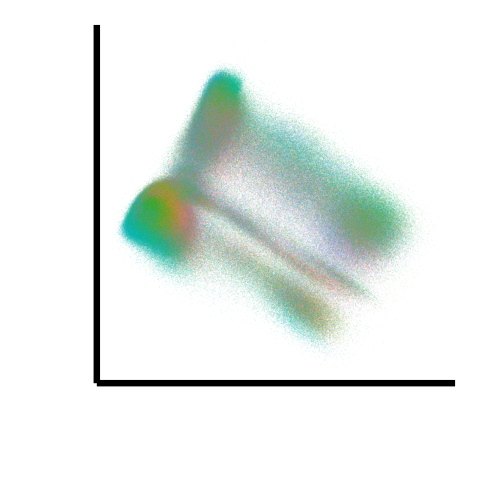

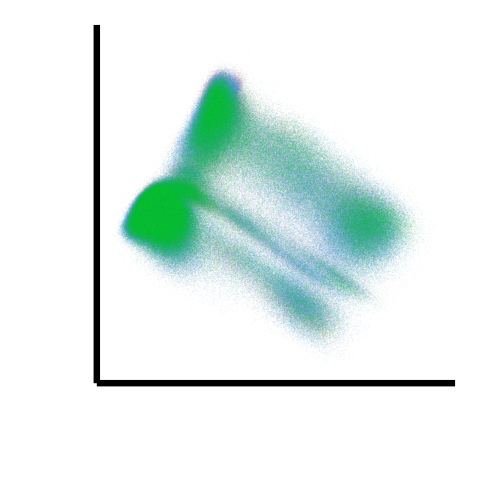

In [6]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot() +
    geom_point(
        data = data.frame(pca_res$x[,c("PC1","PC2")],batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

ggplot() +
    geom_point(
        data = data.frame(pca_res$x[,c("PC1","PC2")],batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "condition"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

In [7]:
harmony_embeddings_all <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/harmony_embeddings_Prop",prop,"_Nmin",n_min,"_topVar",frac,".rds"))
batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/meta_Prop",prop,"_Nmin",n_min,".rds"))

In [8]:
print(head(harmony_embeddings_all))
print(dim(harmony_embeddings_all))

             PC1         PC2        PC3          PC4        PC5         PC6
[1,]  1.99860266  2.30688085  1.4292079  0.950931758  0.2167589 -1.24418177
[2,] -0.03390258  0.24085536  2.4242632 -1.089907647 -2.3870460 -3.54459032
[3,] -2.15002389 -0.70642941  0.5569366 -0.001987076  0.7541414  0.19482760
[4,] -1.76200641 -0.82334876  0.6691382 -0.518159226 -0.5605855  1.34728312
[5,] -1.43563479 -0.71063739  1.2461366 -0.694409657 -0.2739783 -0.05901363
[6,] -1.56857991 -0.05206011 -1.0984572 -0.639709833  1.4455237 -0.57006287
            PC7        PC8          PC9       PC10         PC11       PC12
[1,]  0.2489401  0.8579321 -1.592722271 -0.1588523  0.002364261 -0.5980873
[2,] -0.3348443 -0.2960081  0.803713363 -0.3818554 -0.024890286  0.3154941
[3,]  0.7711156  0.1024833 -0.481610233  0.5489358  0.821775842  1.2230060
[4,]  0.3800929 -1.6927061  0.038944875 -1.1250716 -1.067391597  0.5128490
[5,]  0.6168624 -0.3048199  0.059377962  0.2061057 -0.708734635 -0.4203412
[6,] -0.1170739 -0

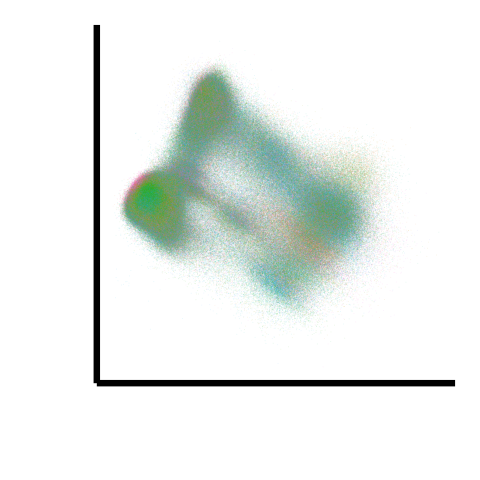

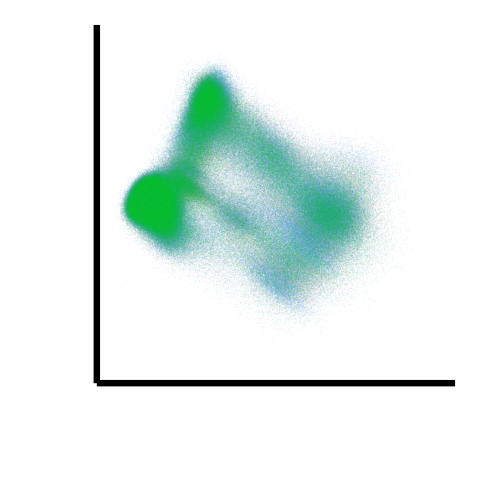

In [9]:

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all,batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all,batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "condition"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

`summarise()` has grouped output by 'key'. You can override using the `.groups`
argument.


key,group,median
<chr>,<chr>,<dbl>
Race,after,2.878582
Race,before,2.647553
Site,after,4.345290
Site,before,3.718097
batch,after,6.507698
batch,before,4.247662
condition,after,2.208206
condition,before,2.106708
individual,after,10.568528


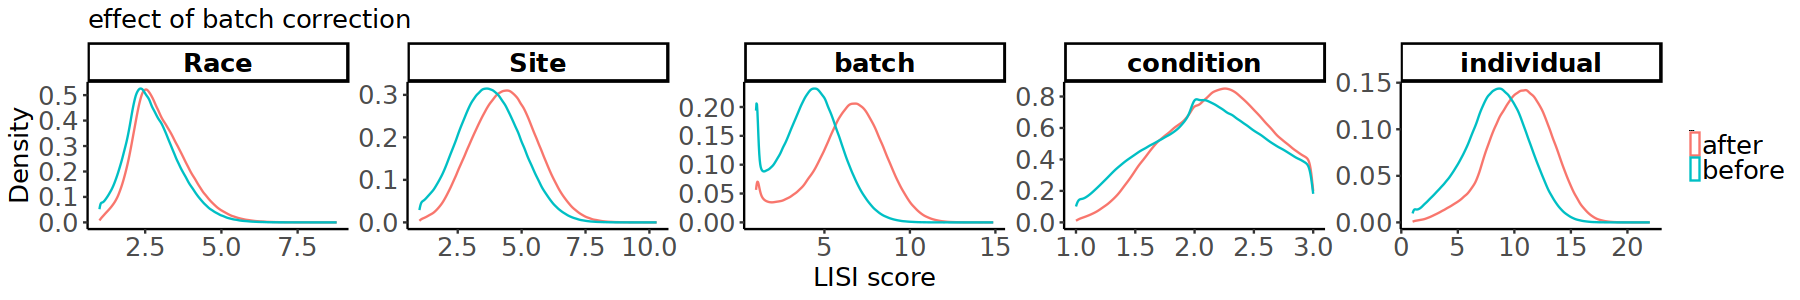

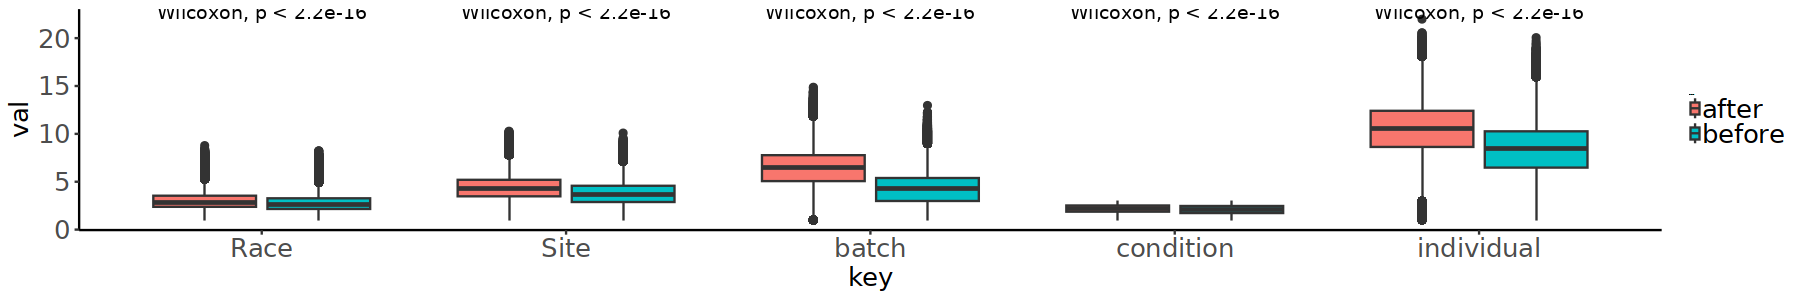

In [10]:
# check LISI score
LISI_df = rbind(
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/LISI_harmony.rds")) %>%
        dplyr::mutate(group = "after"),
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/LISI_PCA.rds")) %>%
        dplyr::mutate(group = "before")
    ) %>%
    dplyr::mutate(key = ifelse(key=="OmiqFileIndex", "individual", key))

LISI_df %>%
    dplyr::group_by(key,group) %>%
    dplyr::summarize(median = median(val))

options(repr.plot.height = 2.5, repr.plot.width = 15)
ggplot(LISI_df) +
      geom_density(
        aes(x  = val, color = group) 
      ) +
      #   scale_x_continuous(limits = c(1, 15))+
      labs(
        title = "effect of batch correction",
        x = "LISI score",
        y = "Density"
      ) +
      facet_wrap( ~ key, scales = "free", ncol = 5) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) 

LISI_df %>% 
  ggplot(aes(x=key, y=val, fill=group)) +
  geom_boxplot() +
  ggpubr::stat_compare_means(method= "wilcox.test") +
  theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) 

In [11]:
# UMAP visualization
umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
umap_res$res_cell = factor(umap_res$res_cell, levels=sort(as.integer(unique(umap_res$res_cell))))

In [12]:
# remove clusters less than cut off
min_cell_cluster = 30
clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi = umap_res$res_cell %in% clu
umap_res = umap_res[clu_logi,]

In [13]:
# Find cluster center
cluster_center <- umap_res %>%
  dplyr::group_by(res_cell) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_cell <- as.character(cluster_center$res_cell)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [14]:
# meta data

batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/meta_Prop",prop,"_Nmin",n_min,".rds"))
batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
  stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
  as.data.frame() %>%
  .[,1] %>%
  gsub("-","_",.)
batch_fl = batch_fl[clu_logi,]
umap_res$subject_id = batch_fl$subject_id
umap_res$time_point = batch_fl$time_point

meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta = merge(umap_res,meta,by="subject_id")
meta = meta[order(match(meta$subject_id, umap_res$subject_id)),]

meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex))
meta_add = dplyr::left_join(umap_res,meta_add,by="subject_id")

meta_total = read.csv("/projects/jinamo@xsede.org/cytof/data/Total_Metadata.csv") %>%
    dplyr::mutate(subject_id = gsub("-","_",Patient)) %>%
    dplyr::distinct(subject_id,Site,Race)
meta_total = meta_total[!(is.na(meta_total$Race) | meta_total$Race==""), ]
meta_total = merge(umap_res,meta_total,by="subject_id")
meta_total = meta_total[order(match(meta_total$subject_id, umap_res$subject_id)),]

umap_res$AtRisk = dplyr::case_when(
  meta$AMP_Group == "FDR" & meta$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  meta$AMP_Group == "GP" & meta$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  meta$AMP_Group == "FDR" & meta$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  meta$AMP_Group == "GP" & meta$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  umap_res$disease == "Control" ~ "Control",
  umap_res$disease == "RA" ~ "RA")
umap_res$AtRisk = factor(umap_res$AtRisk,levels=c("Control","FDR(-)/ACPA(-)","FDR(+)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(+)","RA"))
umap_res$disease = dplyr::case_when(
  umap_res$AtRisk == "FDR(+)/ACPA(+)" | umap_res$AtRisk == "FDR(-)/ACPA(+)" | umap_res$AtRisk == "FDR(+)/ACPA(-)" ~ "AtRiskRA",
  umap_res$AtRisk == "Control" | umap_res$AtRisk == "FDR(-)/ACPA(-)" ~ "Control",
  umap_res$AtRisk == "RA" ~ "RA")
umap_res$disease = factor(umap_res$disease,levels=c("Control","AtRiskRA","RA"))
umap_res$age_at_biopsy <- as.numeric(meta$age_at_biopsy)
umap_res$sex <- as.numeric(factor(meta$sex, c('female', 'male')))
umap_res$ethnicity <- as.numeric(factor(meta$ethnicity, c('not_hispanic', 'hispanic_latino')))
umap_res$AMP_Group <- as.numeric(factor(meta$AMP_Group, c('GP', 'FDR')))
umap_res$CCP <- dplyr::case_when(
    meta$CCP == 'Negative' ~ "at-risk CCP(-)", 
    meta$CCP == 'Positive' ~ "at-risk CCP(+)",
    umap_res$AtRisk == "Control" ~ "Control")
umap_res$CCP <- factor(umap_res$CCP,levels=c("Control","at-risk CCP(-)","at-risk CCP(+)"))
umap_res$CCP30_titer <- as.numeric(meta$CCP30_titer)
umap_res$CCP31_titer <- as.numeric(meta$CCP31_titer)
umap_res$RF <- as.numeric(factor(meta$RF, c('Negative', 'Positive')))
umap_res$RF_IgM_titer <- as.numeric(meta$RF_IgM_titer)
umap_res$RF_IgG_titer <- as.numeric(meta$RF_IgG_titer)
umap_res$RF_IgA_titer <- as.numeric(meta$RF_IgA_titer)
umap_res$Site = meta_total$Site
umap_res$Race = meta_total$Race


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [15]:
get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

umap_res = umap_res %>%
    dplyr::group_by(disease) %>%
    dplyr::mutate(density_disease = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(batch) %>%
    dplyr::mutate(density_batch = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(res_cell) %>%
    dplyr::mutate(density_cluster = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(AtRisk) %>%
    dplyr::mutate(density_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(time_point,AtRisk) %>%
    dplyr::mutate(density_time_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(CCP) %>%
    dplyr::mutate(density_AtRiskCCP = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Site,AtRisk) %>%
    dplyr::mutate(density_site_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Site,disease) %>%
    dplyr::mutate(density_site_condition = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Race,AtRisk) %>%
    dplyr::mutate(density_race_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup()

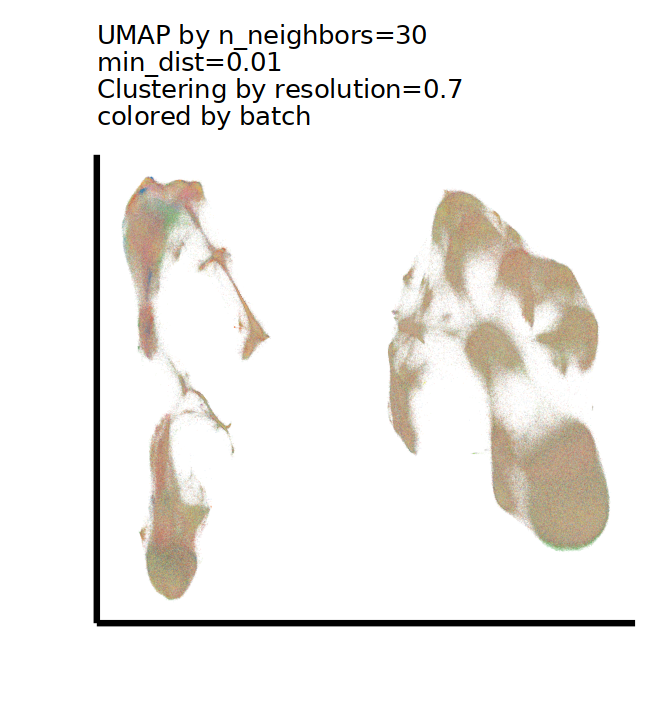

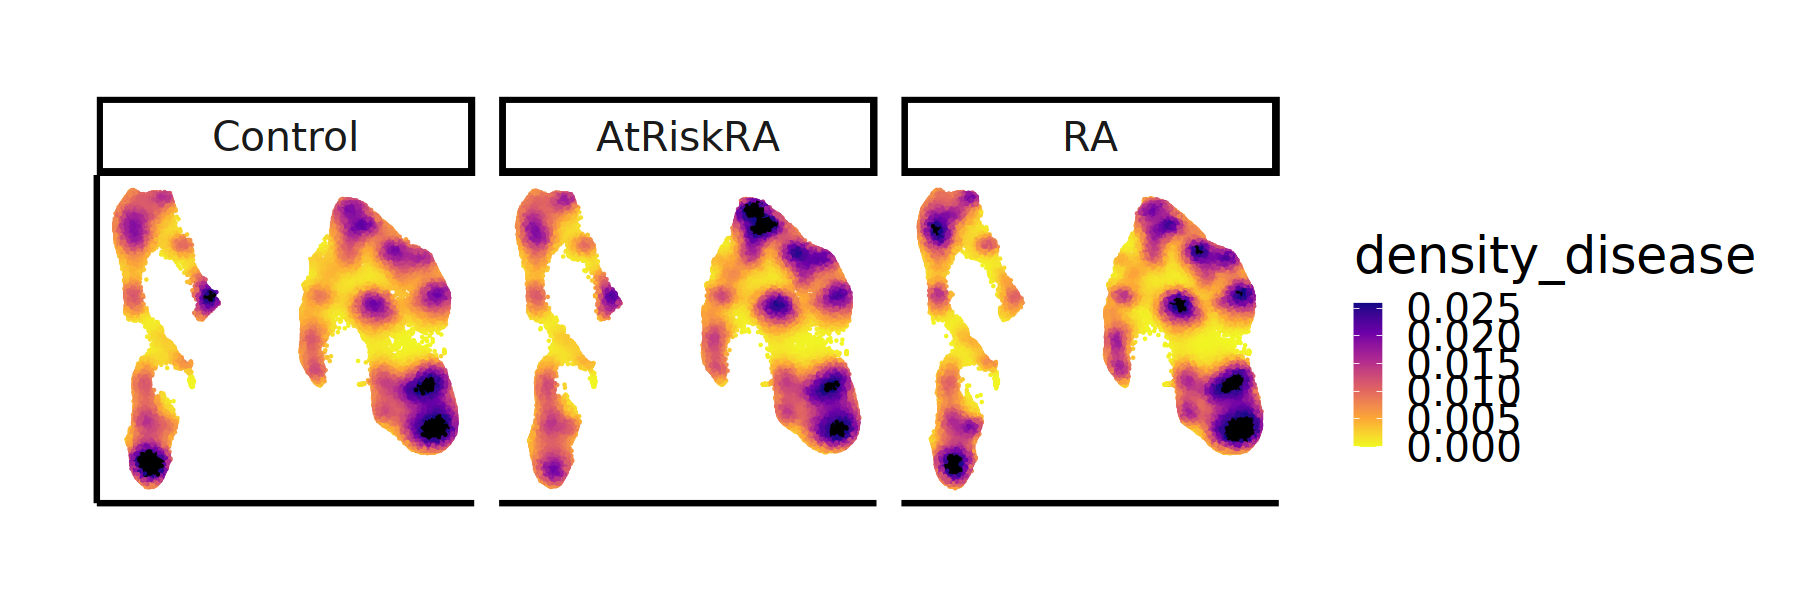

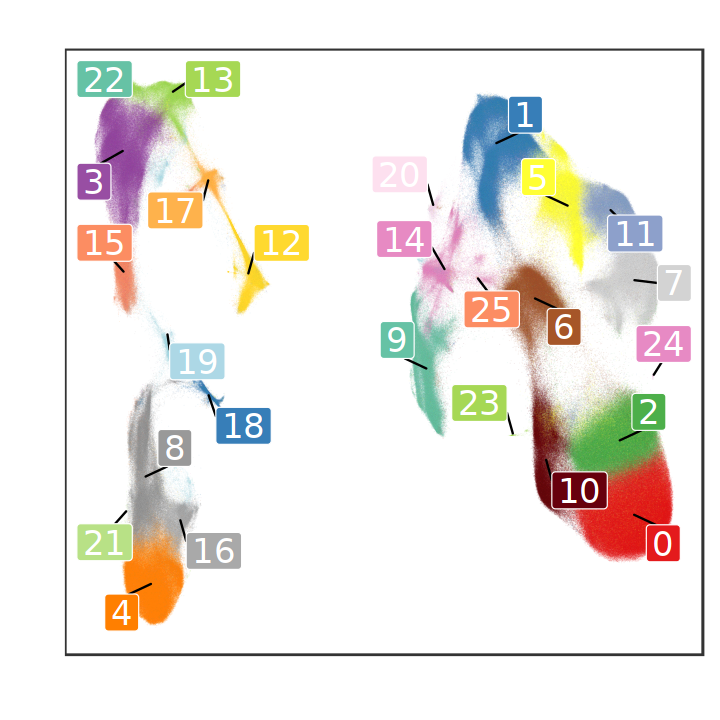

In [16]:


options(repr.plot.height = 6, repr.plot.width = 5.5)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "batch"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#E41A1C",
         "24" = "#377EB8")) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"\nmin_dist=",min_dist,"\nClustering by resolution=",resolution_list,"\ncolored by batch"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=15, face = "italic")
       )
)

options(repr.plot.height = 5, repr.plot.width = 15)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_disease),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma", direction = -1, na.value = "black",limits = c(0, quantile(umap_res$density_disease, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ disease, ncol = 3) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)

options(repr.plot.height = 6, repr.plot.width = 6)
plot(ggplot() +
       geom_point(
         data = umap_res %>% dplyr::mutate(res_cell = factor(res_cell,levels=cluster_df$cluster)),
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "res_cell"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       geom_label_repel(
         data = cluster_center,
         aes(x = UMAP1, y = UMAP2, label = res_cell, fill = res_cell),
         color = "white",segment.color = "black",
           size = 7,
         min.segment.length = 0, seed = 42, box.padding = 0.5
       ) +
       scale_color_manual(values = c(
         "0" = "#E41A1C",
         "1" = "#377EB8",
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#A6D855",
         "24" = "#E78AC4",
         "25" = "#FC8D63",
         "26" = "brown",
         "27" = "#FEB25C",
         "28" = "#377EB9",
         "29" = "lightgreen",
         "30" = "#FDE1EF"
       )) +
       scale_fill_manual(values = c(
         "0" = "#E41A1C",
         "1" = "#377EB8",
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#A6D855",
         "24" = "#E78AC4",
         "25" = "#FC8D63",
         "26" = "brown",
         "27" = "#FEB25C",
         "28" = "#377EB9",
         "29" = "lightgreen",
         "30" = "#FDE1EF"
       )) +
       labs(
         x = "",
         y = "",
         title = ""
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=10)
       ) 
)


In [ ]:
# CNA; covarying neighborhood analysis

In [2]:
obj = readRDS(paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/SeuratObj_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
obj@meta.data$subject_id <- stringr::str_split(obj@meta.data$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)

umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
# remove clusters less than cut off
min_cell_cluster = 30
clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi = umap_res$res_cell %in% clu
umap_res = umap_res[clu_logi,]

# Find cluster center
cluster_center <- umap_res %>%
  dplyr::group_by(res_cell) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_cell <- as.character(cluster_center$res_cell)

Loading required package: SeuratObject

Attaching sp

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [3]:
# meta data

batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/meta_Prop",prop,"_Nmin",n_min,".rds"))
batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
  stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
  as.data.frame() %>%
  .[,1] %>%
  gsub("-","_",.)
batch_fl = batch_fl[clu_logi,]
umap_res$subject_id = batch_fl$subject_id
umap_res$time_point = batch_fl$time_point

meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta = merge(meta,obj@meta.data,by="subject_id")
meta = meta[order(match(meta$subject_id, obj@meta.data$subject_id)),]

meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex))
meta_add = dplyr::left_join(obj@meta.data[,!grepl("CDAI",colnames(obj@meta.data))],meta_add,by="subject_id")

meta_add2 = read.table("/projects/jinamo@xsede.org/cytof/data/clinical_data_for_FAN_from_Kat.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(-c(sex))
meta_add2 = dplyr::left_join(obj@meta.data[,!grepl("CDAI",colnames(obj@meta.data))],meta_add2,by="subject_id")

meta_add3 = read.table("/projects/jinamo@xsede.org/cytof/data/RA_Cleaned_aggregate_vars.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(c(subject_id,HAQ,das28_crp3,bmi,ra_group,pathotype_str,sdai,ccp_type,ccp_range,rf_range,mdtjc28_sum,mdsjc28_sum,diabetes,Race_white,Race_black,Race_multiple,Race_other,MTX,SSZ,HCQ,LEF,TNFi))
meta_add3 = dplyr::left_join(obj@meta.data,meta_add3,by="subject_id")

meta_total = read.csv("/projects/jinamo@xsede.org/cytof/data/Total_Metadata.csv") %>%
    dplyr::mutate(subject_id = gsub("-","_",Patient)) %>%
    dplyr::distinct(subject_id,Site,Race)
meta_total = meta_total[!(is.na(meta_total$Race) | meta_total$Race==""), ]
meta_total = merge(umap_res,meta_total,by="subject_id")
meta_total = meta_total[order(match(meta_total$subject_id, umap_res$subject_id)),]


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [4]:
# merge meta data to Seurat object
obj@meta.data$AtRisk = dplyr::case_when(
  meta$AMP_Group == "FDR" & meta$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  meta$AMP_Group == "GP" & meta$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  meta$AMP_Group == "FDR" & meta$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  meta$AMP_Group == "GP" & meta$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  obj@meta.data$disease == "Control" ~ "Control",
  obj@meta.data$disease == "RA" ~ "RA")
obj@meta.data$age_at_biopsy <- as.numeric(meta$age_at_biopsy)
obj@meta.data$sex <- as.numeric(factor(meta$sex, c('female', 'male')))
obj@meta.data$ethnicity <- as.numeric(factor(meta$ethnicity, c('not_hispanic', 'hispanic_latino')))
obj@meta.data$AMP_Group <- as.numeric(factor(meta$AMP_Group, c('GP', 'FDR')))
obj@meta.data$CCP <- as.numeric(factor(meta$CCP, c('Negative', 'Positive')))
obj@meta.data$CCP30_titer <- as.numeric(meta$CCP30_titer)
obj@meta.data$CCP31_titer <- as.numeric(meta$CCP31_titer)
obj@meta.data$RF <- as.numeric(factor(meta$RF, c('Negative', 'Positive')))
obj@meta.data$RF_IgM_titer <- as.numeric(meta$RF_IgM_titer)
obj@meta.data$RF_IgG_titer <- as.numeric(meta$RF_IgG_titer)
obj@meta.data$RF_IgA_titer <- as.numeric(meta$RF_IgA_titer)
obj@meta.data$batch <- as.numeric(factor(meta$batch))
obj@meta.data$AtRisk = factor(obj@meta.data$AtRisk,levels=c("Control","FDR(+)/ACPA(+)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)","FDR(-)/ACPA(-)","RA"))
obj@meta.data$alt_AtRisk = dplyr::case_when(
  obj@meta.data$AtRisk == "FDR(-)/ACPA(-)" ~ "FDR(-)/ACPA(-)",
  obj@meta.data$AtRisk == "FDR(+)/ACPA(-)" | obj@meta.data$AtRisk == "FDR(-)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(+)/ACPA(+)" ~ "AtRiskRA",
  TRUE ~ "others")
obj@meta.data$ctap <- dplyr::case_when(
  meta$diagnosis == "AtRiskRA" ~ "AtRiskRA",
  meta$diagnosis == "Control" ~ "Control")
obj@meta.data$ctap <- ifelse(is.na(obj@meta.data$ctap),meta$ctap,obj@meta.data$ctap)
obj@meta.data$CDAI <- as.numeric(meta_add$CDAI)
obj@meta.data$krenn_lining <- as.numeric(meta_add$krenn_lining)
obj@meta.data$krenn_inflammation <- as.numeric(meta_add$krenn_inflammation)
obj@meta.data$treatment <- dplyr::case_when(
  meta$diagnosis == "AtRiskRA" ~ "AtRiskRA",
  meta$diagnosis == "Control" ~ "Control")
obj@meta.data$treatment <- ifelse(is.na(obj@meta.data$treatment),meta_add$treatment,obj@meta.data$treatment)
obj@meta.data$disease = dplyr::case_when(
  obj@meta.data$AtRisk == "FDR(+)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(-)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(+)/ACPA(-)" ~ "AtRiskRA",
  obj@meta.data$AtRisk == "Control" | obj@meta.data$AtRisk == "FDR(-)/ACPA(-)" ~ "Control",
  obj@meta.data$AtRisk == "RA" ~ "RA")
obj@meta.data$condition = obj@meta.data$disease
obj@meta.data$condition = factor(obj@meta.data$condition, levels = c('Control', 'AtRiskRA', "RA"))
obj@meta.data$CRP <- as.numeric(meta_add2$crp_result)
obj@meta.data$ESR <- as.numeric(meta_add2$esr_result)
obj@meta.data$RA_duration_years <- as.numeric(meta_add2$RA_duration_years)
obj@meta.data$CDAI <- ifelse(is.na(obj@meta.data$CDAI), as.numeric(meta_add2$cdai), obj@meta.data$CDAI)
obj@meta.data$SDAI <- as.numeric(meta_add3$sdai)
obj@meta.data$DAS28_ESR <- as.numeric(meta_add2$das28_esr3)
obj@meta.data$DAS28_CRP <- as.numeric(meta_add3$das28_crp3)
obj@meta.data$CCP31_titer <- ifelse(obj@meta.data$condition == "RA", as.numeric(meta_add2$ccp_result), obj@meta.data$CCP31_titer)
obj@meta.data$CCP31_cutoff <- as.numeric(meta_add3$ccp_range)
obj@meta.data$RF_IgM_titer <- ifelse(obj@meta.data$condition == "RA", as.numeric(meta_add2$rf_result), obj@meta.data$RF_IgM_titer)
obj@meta.data$RF_IgM_cutoff <- as.numeric(meta_add3$rf_range)
obj@meta.data$smoke_hx <- as.factor(meta_add2$smoke_hx)
obj@meta.data$smoke_current <- as.factor(meta_add2$smoke_current)
obj@meta.data$Methotrexate_only <- meta_add2$Methotrexate_only
obj@meta.data$TNFi_possible_nbDMARD <- meta_add2$TNFi_possible_nbDMARD
obj@meta.data$other_bDMARD <- meta_add2$other_bDMARD
obj@meta.data$other_nbDMARD_no_bDMARD <- meta_add2$other_nbDMARD_no_bDMARD
obj@meta.data$no_DMARD <- meta_add2$no_DMARD
obj@meta.data$bDMARD <- meta_add2$bDMARD
obj@meta.data$nbDMARD <- meta_add2$nbDMARD
obj@meta.data$Prednisone <- meta_add2$Prednisone
obj@meta.data$Prednisone_GE_7.5 <- ifelse(obj@meta.data$Prednisone, meta_add2$Prednisone_GE_7.5, FALSE)
obj@meta.data$time_point <- batch_fl$time_point
obj@meta.data$Site <- meta_total$Site
obj@meta.data$Race <- meta_total$Race

In [5]:
# Control vs AtRiskRA 

logi = obj$condition %in% c("Control","AtRiskRA")
obj_sub = readRDS(paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/SeuratObj_Control_AtRiskRA_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))


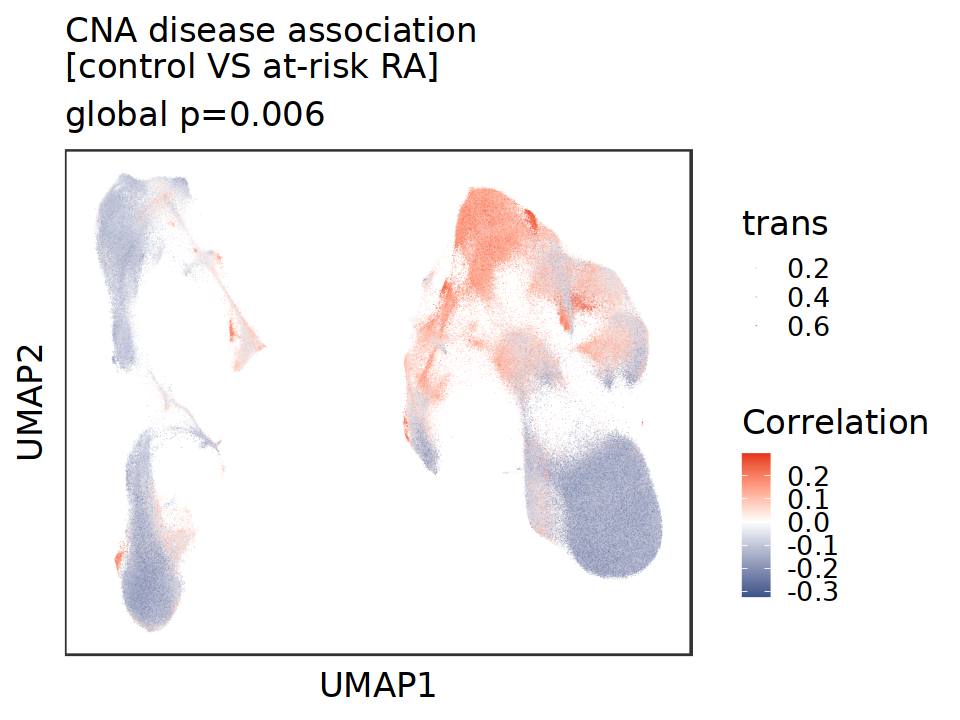

In [6]:
# positive correlation means association with at-risk RA
options(repr.plot.height = 6, repr.plot.width = 8)
cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs)) %>%
    dplyr::mutate(trans = abs(cna_ncorrs)*2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
       geom_point(
         aes(color = cna_ncorrs, alpha = trans),
           size = 0.001, stroke = 0, shape = 16
       ) +
       scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab"  ) +
       labs(
         x = "UMAP1",
         y = "UMAP2",
         title = 'CNA disease association\n[control VS at-risk RA]', 
         color = 'Correlation',
         subtitle = sprintf('global p=%0.3f', obj_sub@reductions$cna@misc$p)
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


,cluster,size,model.pvalue,conditionAtRiskRA.OR,conditionAtRiskRA.OR.95pct.ci.lower,conditionAtRiskRA.OR.95pct.ci.upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster0,cluster0,127818,0.0437147681,0.7940251,0.6360149,0.9912911
cluster1,cluster1,113775,0.0002599211,1.4747811,1.2484941,1.7420822
cluster10,cluster10,43480,0.7309630923,0.9613646,0.8293621,1.1143767
cluster11,cluster11,37121,0.0618274786,1.1723484,1.0321586,1.3315791
cluster12,cluster12,49796,0.8053759734,1.0415431,0.9275553,1.1695388
cluster13,cluster13,30475,0.5096055244,0.8483963,0.6885912,1.0452883
cluster14,cluster14,25266,0.0000861521,1.3097743,1.1704619,1.4656681
cluster15,cluster15,21412,0.2979221019,0.8465501,0.6764671,1.0593967
cluster16,cluster16,12478,0.3229480351,1.1518187,0.9664599,1.3727277


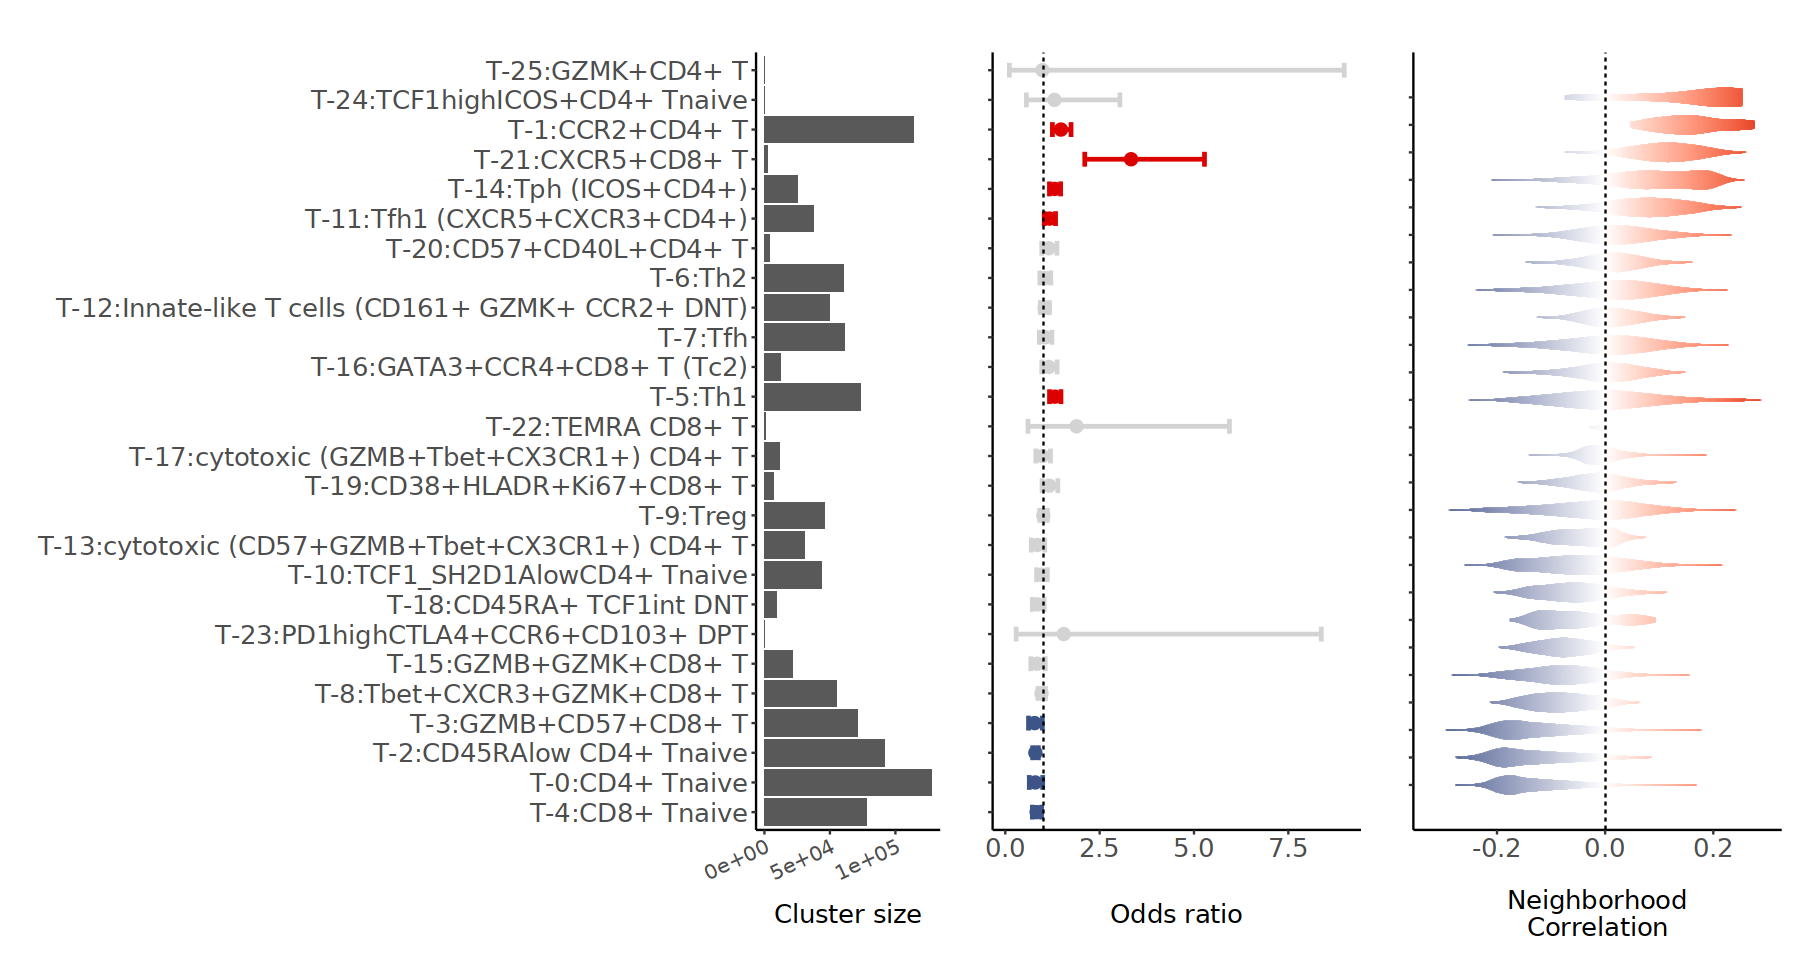

In [7]:
cor_pos = obj_sub@meta.data$cna_ncorrs_fdr05
cor_pos = cor_pos[cor_pos > 0]
# summary(cor_pos)
cor_neg = obj_sub@meta.data$cna_ncorrs_fdr05
cor_neg = cor_neg[cor_neg < 0]
# summary(cor_neg)

ord = cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(med = median(cna_ncorrs)) %>%
    dplyr::arrange(med) %>%
    .$res_cell

p <- cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::mutate(res_cell = factor(res_cell,levels=ord)) %>%
    ggplot(aes(x=res_cell, y=cna_ncorrs)) + 
    geom_violin(trim=TRUE, scale = "width")

mywidth <- .35 # bit of trial and error
# This is all you need for the fill: 
vl_fill <- data.frame(ggplot_build(p)$data) %>%
  mutate(xnew = x- mywidth*violinwidth, xend = x+ mywidth*violinwidth) 

# Bit convoluted for the outline, need to be rearranged: the order matters
vl_poly <- 
  vl_fill %>% 
  select(xnew, xend, y, group) %>%
  pivot_longer(-c(y, group), names_to = "oldx", values_to = "x") %>% 
  arrange(y) %>%
  split(., .$oldx) %>%
  map(., function(x) {
    if(all(x$oldx == "xnew")) x <- arrange(x, desc(y))
    x
    }) %>%
  bind_rows()


if (length(cor_pos)!=0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos), max(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +   
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)!=0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =15),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  }

# MASC: Mixed-effects association testing for single cells
## Sci Transl Med. 2018 Oct 17;10(463):eaaq0305.

masc = readRDS(file = paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/MASC_Control_AtRiskRA_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
masc
g2 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster),
                cluster = factor(cluster,levels=ord)) %>%
  ggplot(., aes(y=cluster, x=OR, colour=col)) + 
  geom_point(position=position_dodge(width=0.3), size=3) +
  geom_errorbarh(aes(xmin=CIlower, xmax=CIupper), position = position_dodge(0.3), height=0.5, linewidth = 1) +
  scale_color_manual(values = c('#3C5488FF' = '#3C5488FF', '#DC0000FF' = '#DC0000FF', "lightgray" = "lightgray")) + 
  scale_y_discrete(labels=cluster_df %>%
    magrittr::set_rownames(cluster_df$cluster) %>%
    .[ord,] %>% .$clu_name) +
  geom_vline(xintercept=1, linetype='dashed', color='black') +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "Odds ratio")

g3 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster),
                cluster = factor(cluster,levels=ord)) %>%
  ggplot(., aes(y=cluster, x=size)) + 
  geom_bar(stat = "identity", position=position_dodge()) + 
  scale_y_discrete(labels=paste0("T-",
                                 cluster_df %>%
                                   magrittr::set_rownames(cluster_df$cluster) %>%
                                   .[ord,] %>% .$cluster,
                                 ":",
                                 cluster_df %>%
                                   magrittr::set_rownames(cluster_df$cluster) %>%
                                   .[ord,] %>% .$clu_name)
  ) +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 12, angle = 25, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "Cluster size")
options(repr.plot.height = 8, repr.plot.width = 15)
(g3+g2+g1)+plot_layout(widths = c(1,2,2))

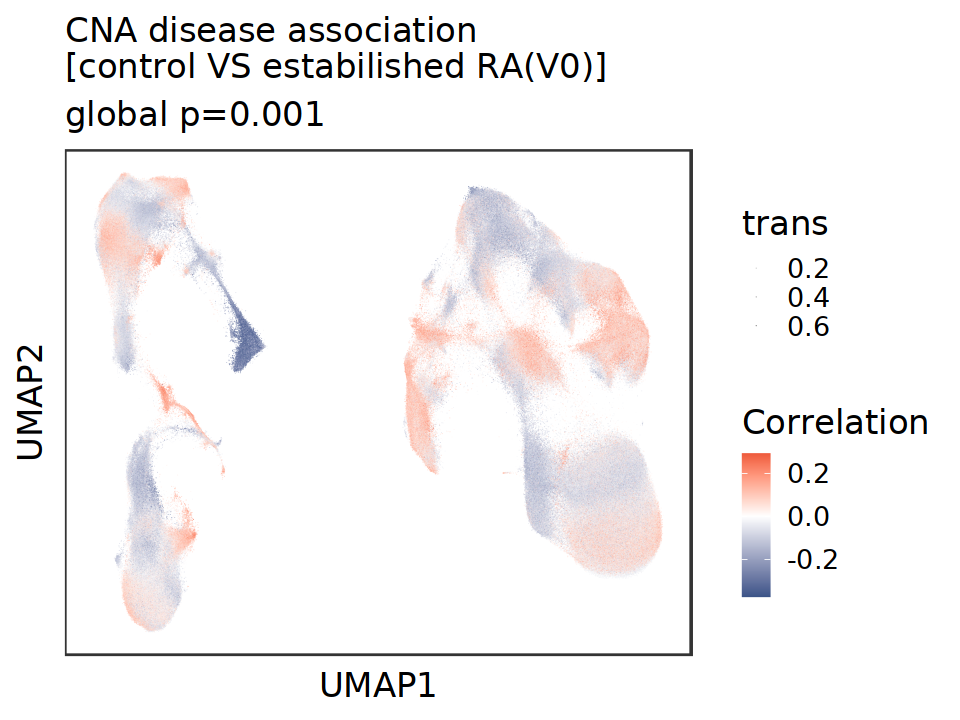

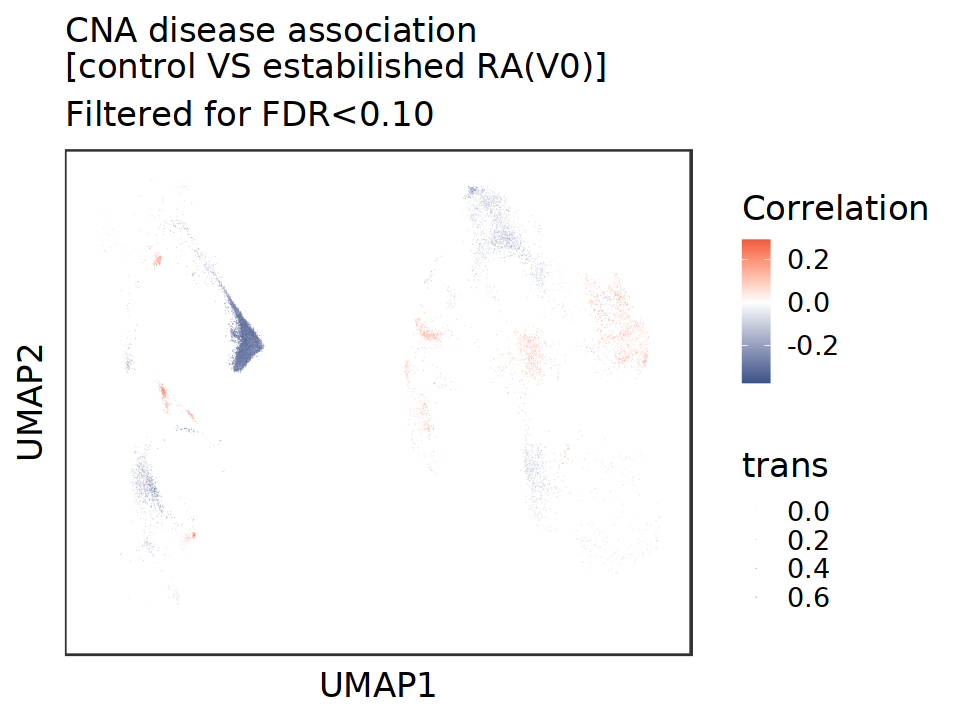

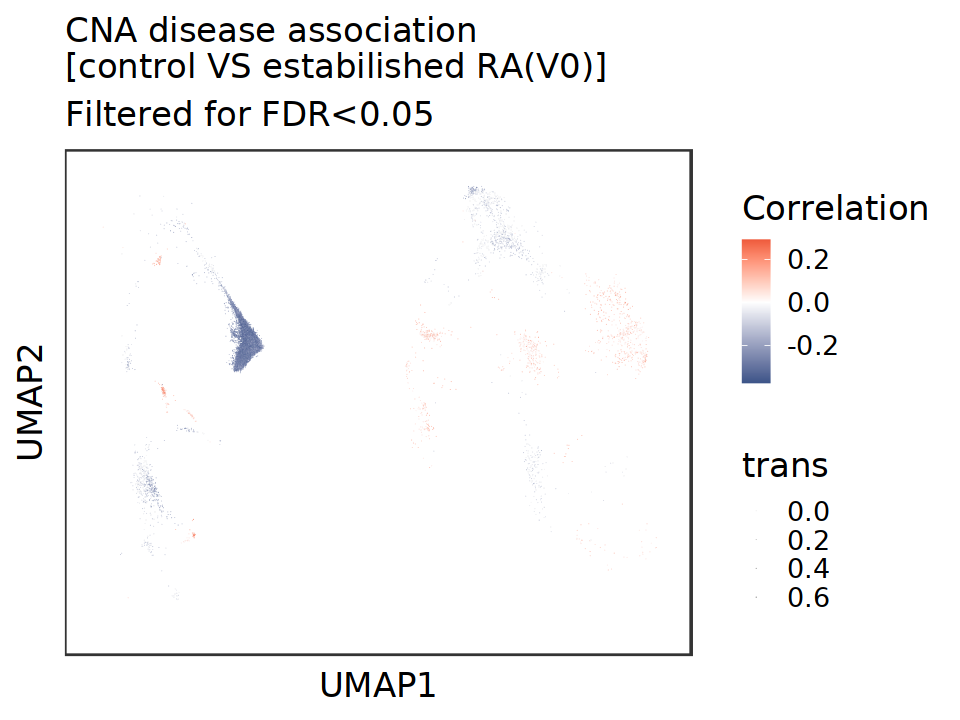

In [8]:
# Control vs RA(V0)

logi = (obj$condition %in% c("RA","Control")) & (obj$time_point == "V0")
obj_sub = readRDS(paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/SeuratObj_Control_RAV0_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
# positive correlation means association with estabilished RA
options(repr.plot.height = 6, repr.plot.width = 8)
cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs)) %>%
    dplyr::mutate(trans = abs(cna_ncorrs)*2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
       geom_point(
         aes(color = cna_ncorrs, alpha = trans),
           size = 0.001, stroke = 0, shape = 16
       ) +
       scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab"  ) +
       labs(
         x = "UMAP1",
         y = "UMAP2",
         title = 'CNA disease association\n[control VS estabilished RA(V0)]', 
         color = 'Correlation',
         subtitle = sprintf('global p=%0.3f', obj_sub@reductions$cna@misc$p)
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )

options(repr.plot.height = 6, repr.plot.width = 8)
cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs_fdr10)) %>%
    dplyr::mutate(trans = abs(cna_ncorrs_fdr10)*2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
       geom_point(
         aes(color = cna_ncorrs_fdr10, alpha = trans),
           size = 0.001, stroke = 0, shape = 16
       ) +
       scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab"  ) +
       labs(
         x = "UMAP1",
         y = "UMAP2",
         title = 'CNA disease association\n[control VS estabilished RA(V0)]', 
         color = 'Correlation',
         subtitle = "Filtered for FDR<0.10"
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )

options(repr.plot.height = 6, repr.plot.width = 8)
cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs_fdr05)) %>%
    dplyr::mutate(trans = abs(cna_ncorrs_fdr05)*2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
       geom_point(
         aes(color = cna_ncorrs_fdr05, alpha = trans),
           size = 0.001, stroke = 0, shape = 16
       ) +
       scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab"  ) +
       labs(
         x = "UMAP1",
         y = "UMAP2",
         title = 'CNA disease association\n[control VS estabilished RA(V0)]', 
         color = 'Correlation',
         subtitle = "Filtered for FDR<0.05"
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )

,cluster,size,model.pvalue,conditionRA.OR,conditionRA.OR.95pct.ci.lower,conditionRA.OR.95pct.ci.upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster0,cluster0,158531,5.454581e-01,1.0592688,0.89496307,1.2537393
cluster1,cluster1,101179,5.529067e-01,0.9482403,0.85772939,1.0483022
cluster10,cluster10,49944,7.134643e-01,0.9597169,0.84808343,1.0860446
cluster11,cluster11,41231,5.131554e-02,1.1901114,1.06100140,1.3349324
cluster12,cluster12,38123,4.860500e-09,0.4400042,0.31814435,0.6085403
cluster13,cluster13,36031,5.819381e-01,0.8693590,0.76520752,0.9876864
cluster14,cluster14,26767,3.391974e-03,1.1986771,1.08737648,1.3213702
cluster15,cluster15,23362,1.746788e-01,0.7989280,0.65314213,0.9772543
cluster16,cluster16,18809,1.185624e-02,1.5414994,1.32034057,1.7997027


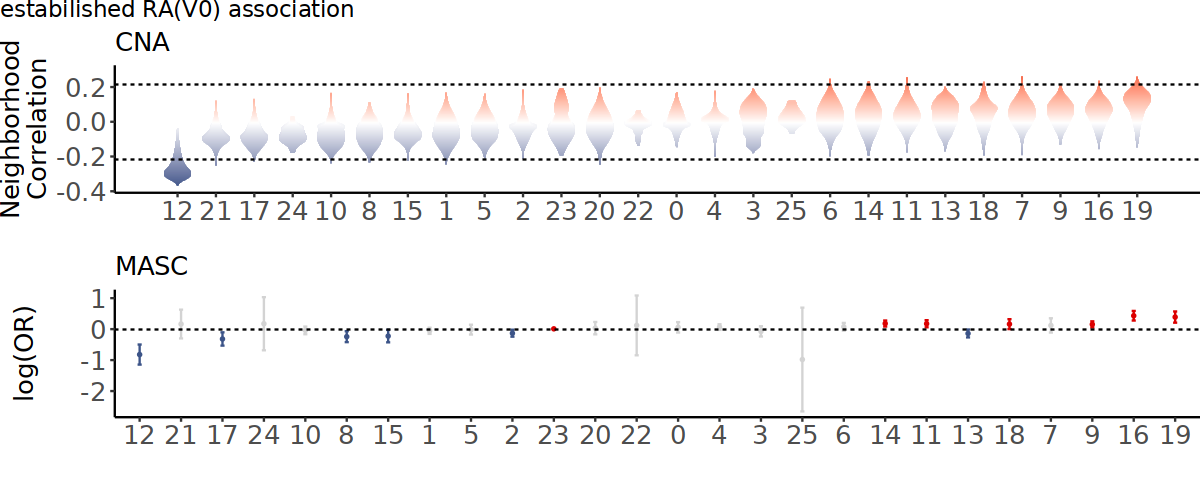

In [9]:
cor_pos = obj_sub@meta.data$cna_ncorrs_fdr05
cor_pos = cor_pos[cor_pos > 0]
# summary(cor_pos)
cor_neg = obj_sub@meta.data$cna_ncorrs_fdr05
cor_neg = cor_neg[cor_neg < 0]
# summary(cor_neg)

ord = cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(med = median(cna_ncorrs)) %>%
    dplyr::arrange(med) %>%
    .$res_cell

p <- cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
    dplyr::mutate(res_cell = factor(res_cell,levels=ord)) %>%
    ggplot(aes(x=res_cell, y=cna_ncorrs)) + 
    geom_violin(trim=TRUE, scale = "width")

mywidth <- .35 # bit of trial and error
# This is all you need for the fill: 
vl_fill <- data.frame(ggplot_build(p)$data) %>%
  mutate(xnew = x- mywidth*violinwidth, xend = x+ mywidth*violinwidth) 

# Bit convoluted for the outline, need to be rearranged: the order matters
vl_poly <- 
  vl_fill %>% 
  select(xnew, xend, y, group) %>%
  pivot_longer(-c(y, group), names_to = "oldx", values_to = "x") %>% 
  arrange(y) %>%
  split(., .$oldx) %>%
  map(., function(x) {
    if(all(x$oldx == "xnew")) x <- arrange(x, desc(y))
    x
    }) %>%
  bind_rows()

if (length(cor_pos)!=0 & length(cor_neg)!=0) {
  g1 = ggplot() +
    geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
    geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
    scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
    scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
    geom_hline(yintercept=c(min(cor_pos), max(cor_neg)), linetype='dashed', color='black') +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size =15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "CNA",
         x = "",
         y = "Neighborhood\nCorrelation") 
} else if (length(cor_pos)!=0 & length(cor_neg)==0) {
  g1 = ggplot() +
    geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
    geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
    scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
    scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
    geom_hline(yintercept=c(min(cor_pos)), linetype='dashed', color='black') +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size =15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "CNA",
         x = "",
         y = "Neighborhood\nCorrelation") 
} else if (length(cor_pos)==0 & length(cor_neg)!=0) {
  g1 = ggplot() +
    geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
    geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
    scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
    scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
    geom_hline(yintercept=c(min(cor_neg)), linetype='dashed', color='black') +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size =15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "CNA",
         x = "",
         y = "Neighborhood\nCorrelation") 
} else if (length(cor_pos)==0 & length(cor_neg)==0) {
  g1 = ggplot() +
    geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
    geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
    scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
    scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
    theme_classic() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "none",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size =15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) +
    labs(title = "CNA",
         x = "",
         y = "Neighborhood\nCorrelation") 
}

# MASC: Mixed-effects association testing for single cells
## Sci Transl Med. 2018 Oct 17;10(463):eaaq0305.

masc = readRDS(file = paste0("/projects/jinamo@xsede.org/cytof/data/T_cells/MASC_Control_RAV0_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
masc
g2 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cluster = gsub("cluster","",cluster),
                cluster = factor(cluster,levels=ord)) %>%
  ggplot(., aes(y=cluster, x=log(OR), colour=col)) + 
  geom_point(position=position_dodge(width=0.3), size=0.5) +
  geom_errorbarh(aes(xmin=log(CIlower), xmax=log(CIupper)), position = position_dodge(0.3), height=0.1) +
  scale_color_manual(values = c('#3C5488FF' = '#3C5488FF', '#DC0000FF' = '#DC0000FF', "lightgray" = "lightgray")) + 
  geom_vline(xintercept=0, linetype='dashed', color='black') +
  theme_classic() +
  coord_flip() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "MASC",
       y = "",
       x = "log(OR)")

options(repr.plot.height = 4, repr.plot.width = 10)
(g1/guide_area()/g2) + 
    plot_layout(heights = c(3,0,3),guides = "collect") +
    plot_annotation(title = 'estabilished RA(V0) association')& theme(plot.margin = unit(c(0,0,0,0), "cm"))